# Brute force algorithm

naive implementation using DTW and TWED distances as a control case for future implementations.

Here we will compute distance matrix for a given dataset and save the result to disk. Then, using this matrix we will evaluate performance on 1-nearest neighbor classification and Average Mean Presicion at K (AP@K)

In [59]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
import multiprocessing as mp
import os
import matplotlib.pyplot as plt
%matplotlib inline

# DTW

compute distance matrix between test and train datasets using DTW distance from [here](https://github.com/pierre-rouanet/dtw)

**very expensive executions**

In [3]:
from dtw import dtw, accelerated_dtw

In [4]:
def distance_matrix(X_train, X_test):
    # compute distances between each time series on test set and train set
    n = len(X_train)
    m = len(X_test)
    res = np.ones((n, m)) * -1
    for i in range(n):
        for j in range(m):
            d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(X_train[i], X_test[j], 'cosine')
            res[i][j] = d
    return res

def worker(X_train, X_test, i_subset, j_subset, out_q):
    try:
        n = len(X_train)
        m = len(X_test)
        rows = np.ones((n,m)) *  -1
        for i in range(n):
            for j in range(m):
                d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(X_train[i], X_test[j], 'cosine')
                rows[i][j] = d
        out_q.put((i_subset, j_subset, rows))
    except:
        print("worker failed")
    finally:
        print("done")

# this code doesnt work on ipython notebooks when using windows system.
def dmatrix_multiprocessing(X_train, X_test, n_process):
    n = len(X_train)
    m = len(X_test)
    n_subset = n // n_process
    man = mp.Manager()
    result_queue = man.Queue()
    jobs = []
    for k in range(n_process):
        i_subset = k * n_subset
        j_subset = (k+1) * n_subset
        if j_subset > n:
            j_subset = n
        X_train_subset = X_train[i_subset:j_subset]
        jobs.append(mp.Process(target=worker, 
                               args=(X_train_subset, X_test, i_subset, j_subset, result_queue)))
        jobs[-1].start()
    
    for p in jobs:
        p.join()
    
    dmatrix = np.zeros((n, m))
    num_res = result_queue.size()
    while num_ress > 0:
        i_subset, j_subset, rows_subset = result_queue.get()
        dmatrix[i_subset:j_subset] = rows_subset
    
    return dmatrix

In [7]:
%%time
# dataset train size 100, test size 25, 6 classes

path = "/home/frmunoz/Documents/tesis/data/plasticc_subsets/scenario1_ratio_2-8/"
train_d = np.load(os.path.join(path, "train_d_n100_c6.npy"), allow_pickle=True)
test_d = np.load(os.path.join(path, "test_d_n25_c6.npy"), allow_pickle=True)

d_matrix_100_25_6 = distance_matrix(train_d, test_d)
d_matrix_100_25_6.shape

CPU times: user 5.83 s, sys: 9.65 ms, total: 5.83 s
Wall time: 5.84 s


(100, 25)

for more big datasets, please run the multiprocessing algorithm from terminal, here we will just load them

## 1-nearest neighbor classification

having the distance matrix we will classify each time series on the test set using the training set. 

The procedure will be:

1. For each column on the distance matrix, get the clossest distance
2. Check training and test label looking for match. 
3. Final accuracy will be the number of matches divided by the total number of test samples.

In [73]:
def bruteforce_classifier(dataset_folder, dmatrix_folder, n1, n2, c, dist_type="dtw", input_dmatrix=None):
    if dist_type == "dtw":
        dmatrix = np.load(dmatrix_folder + "dmatrix_n{}_m{}_c{}.npy".format(n1, n2, c), allow_pickle=True)
    elif dist_type == "twed":
        dmatrix = np.load(dmatrix_folder + "dmatrix_n{}_m{}_c{}_twed.npy".format(n1, n2, c), allow_pickle=True)
    else:
        dmatrix = input_dmatrix
    train_labels = np.load(dataset_folder + "train_l_n{}_c{}.npy".format(n1, c), allow_pickle=True)
    test_labels = np.load(dataset_folder + "test_l_n{}_c{}.npy".format(n2, c), allow_pickle=True)
    
    n = len(train_labels)
    m = len(test_labels)
    count = 0
    pred_label = []
#     print(m)
    for j in range(m):
        dmin = np.inf
        mink = -1
        for i in range(n):
            if dmatrix[i][j] < dmin:
                dmin = dmatrix[i][j]
                mink = i
        pred_label.append(train_labels[mink])
        if test_labels[j] == train_labels[mink]:
            count += 1
#     print(len(pred_label))
    return count, count/m, np.array(pred_label), test_labels

In [74]:
# loading matrix
path1 = "/home/frmunoz/Documents/tesis/data/plasticc_subsets/scenario1_ratio_2-8/"
path2 = "/home/frmunoz/Documents/tesis/data/bruteforce_dmatrix/scenario1_ratio_2-8/"
ratio = 2/8 # 20% test, 80% train
n1_arr = np.array([100, 500, 1000, 2000, 4000, 5000], dtype=int)
n2_arr = (n1_arr * ratio).astype(int)
c = 6

acc_classifier_dtw = []
test_labels_dtw = []
pred_labels_dtw = []
for n1, n2 in zip(n1_arr, n2_arr):
    count, acc, pred_label, test_label = bruteforce_classifier(path1, path2, n1, n2, c, dist_type="dtw")
    print("accuracy for dataset [%d, %d, %d]:" % (n1, n2, c), acc)
    acc_classifier_dtw.append(acc)
    pred_labels_dtw.append(pred_label)
    test_labels_dtw.append(test_label)

accuracy for dataset [100, 25, 6]: 0.2
accuracy for dataset [500, 125, 6]: 0.248
accuracy for dataset [1000, 250, 6]: 0.28
accuracy for dataset [2000, 500, 6]: 0.27
accuracy for dataset [4000, 1000, 6]: 0.258
accuracy for dataset [5000, 1250, 6]: 0.2464


Normalized confusion matrix
              precision    recall  f1-score   support

        15.0       0.04      0.01      0.02        77
        16.0       0.27      0.04      0.07       145
        42.0       0.21      0.49      0.29       187
        62.0       0.08      0.12      0.09        76
        65.0       0.30      0.24      0.27       153
        90.0       0.41      0.31      0.36       362

    accuracy                           0.26      1000
   macro avg       0.22      0.20      0.18      1000
weighted avg       0.28      0.26      0.24      1000



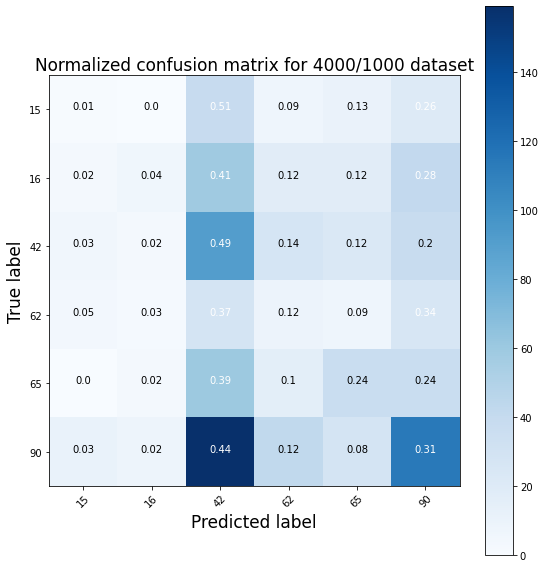

In [72]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=17)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

# Compute confusion matrix for last test
N = 4
y_test = test_labels_dtw[N]
y_pred = pred_labels_dtw[N]
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = [15, 16, 42, 62, 65, 90]
# plt.figure(figsize=(6, 6))
# plot_confusion_matrix(cnf_matrix, classes=class_names,
#                       title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for %d/%d dataset' % (n1_arr[N], n2_arr[N]))

print(classification_report(y_test, y_pred))

## Mean Average Precision at K

In [10]:
def average_precision(target_test, targets_train, predicted_targets_idx):
    
    n_tp_total = np.sum([target_test == targets_train[i] for i in predicted_targets_idx])
    if n_tp_total == 0:
        return 0
    k = len(predicted_targets_idx)
    ap_sum = 0
    for i in range(k):
        tp_seen = 0
        if target_test == targets_train[predicted_targets_idx[i]]:
            for j in range(i+1):
                if target_test == targets_train[predicted_targets_idx[j]]:
                    tp_seen += 1
        ap_sum += tp_seen / (i+1)
    return ap_sum / n_tp_total

def m_av_p_k(dataset_folder, dmatrix_folder, n1, n2, c, k, dist_type="dtw", input_dmatrix=None):
    if dist_type == "dtw":
        dmatrix = np.load(dmatrix_folder + "dmatrix_n{}_m{}_c{}.npy".format(n1, n2, c), allow_pickle=True)
    elif dist_type == "twed":
        dmatrix = np.load(dmatrix_folder + "dmatrix_n{}_m{}_c{}_twed.npy".format(n1, n2, c), allow_pickle=True)
    else:
        dmatrix = input_dmatrix
    train_labels = np.load(dataset_folder + "train_l_n{}_c{}.npy".format(n1, c), allow_pickle=True)
    test_labels = np.load(dataset_folder + "test_l_n{}_c{}.npy".format(n2, c), allow_pickle=True)
    
    n = len(train_labels)
    m = len(test_labels)
    mapk = []
    for j in range(m):
        best_idx_sort = np.argsort(dmatrix[:,j])[::-1]
        best_idx_sort_k = best_idx_sort[:k]
        apk = average_precision(test_labels[j], train_labels, best_idx_sort_k)
        mapk.append(apk)
    
    return np.sum(mapk)/ m, mapk

In [13]:
# loading matrix
mapk_dtw = []
for n1, n2 in zip(n1_arr, n2_arr):
    mapk, vec = m_av_p_k(path1, path2, n1, n2, c, 10, dist_type="dtw")
    print("mAP@k for dataset [%d, %d, %d], and k=%d:" % (n1, n2, c, 10), mapk)
    mapk_dtw.append(mapk)

mAP@k for dataset [100, 25, 6], and k=10: 0.28263756613756613
mAP@k for dataset [500, 125, 6], and k=10: 0.29329639455782314
mAP@k for dataset [1000, 250, 6], and k=10: 0.320765141723356
mAP@k for dataset [2000, 500, 6], and k=10: 0.2567565863567649
mAP@k for dataset [4000, 1000, 6], and k=10: 0.2558541260393046
mAP@k for dataset [5000, 1250, 6], and k=10: 0.1982154838750315


# TWED

compute distance matrix between test and train datasets using TWED distance from [here](https://en.wikipedia.org/wiki/Time_Warp_Edit_Distance)

elasticity parameter **nu** and penalty paramete **\_lambda** are set to 1 and 0.001 respectively in an arbitrary way (should be fit)

**very expensive executions**

In [27]:
def Dlp(A, B, p=2):
    cost = np.sum(np.power(np.abs(A - B), p))
    return np.power(cost, 1 / p)


def twed(A, timeSA, B, timeSB, nu, _lambda):
    # [distance, DP] = TWED( A, timeSA, B, timeSB, lambda, nu )
    # Compute Time Warp Edit Distance (TWED) for given time series A and B
    #
    # A      := Time series A (e.g. [ 10 2 30 4])
    # timeSA := Time stamp of time series A (e.g. 1:4)
    # B      := Time series B
    # timeSB := Time stamp of time series B
    # lambda := Penalty for deletion operation
    # nu     := Elasticity parameter - nu >=0 needed for distance measure
    # Reference :
    #    Marteau, P.; F. (2009). "Time Warp Edit Distance with Stiffness Adjustment for Time Series Matching".
    #    IEEE Transactions on Pattern Analysis and Machine Intelligence. 31 (2): 306–318. arXiv:cs/0703033
    #    http://people.irisa.fr/Pierre-Francois.Marteau/

    # Check if input arguments
    if len(A) != len(timeSA):
        print("The length of A is not equal length of timeSA")
        return None, None

    if len(B) != len(timeSB):
        print("The length of B is not equal length of timeSB")
        return None, None

    if nu < 0:
        print("nu is negative")
        return None, None

    # Add padding
    A = np.array([0] + list(A))
    timeSA = np.array([0] + list(timeSA))
    B = np.array([0] + list(B))
    timeSB = np.array([0] + list(timeSB))

    n = len(A)
    m = len(B)
    # Dynamical programming
    DP = np.zeros((n, m))

    # Initialize DP Matrix and set first row and column to infinity
    DP[0, :] = np.inf
    DP[:, 0] = np.inf
    DP[0, 0] = 0

    # Compute minimal cost
    for i in range(1, n):
        for j in range(1, m):
            # Calculate and save cost of various operations
            C = np.ones((3, 1)) * np.inf
            # Deletion in A
            C[0] = (DP[i - 1, j] + Dlp(A[i - 1], A[i]) + nu * (timeSA[i] - timeSA[i - 1]) + _lambda)
            # Deletion in B
            C[1] = (
                DP[i, j - 1]
                + Dlp(B[j - 1], B[j])
                + nu * (timeSB[j] - timeSB[j - 1])
                + _lambda
            )
            # Keep data points in both time series
            C[2] = (
                DP[i - 1, j - 1]
                + Dlp(A[i], B[j])
                + Dlp(A[i - 1], B[j - 1])
                + nu * (abs(timeSA[i] - timeSB[j]) + abs(timeSA[i - 1] - timeSB[j - 1]))
            )
            # Choose the operation with the minimal cost and update DP Matrix
            DP[i, j] = np.min(C)
    distance = DP[n - 1, m - 1]
    return distance, DP

In [30]:
%%time
path = "/home/frmunoz/Documents/tesis/data/plasticc_subsets/scenario1_ratio_2-8/"
train_d = np.load(os.path.join(path, "train_d_n100_c6.npy"), allow_pickle=True)
test_d = np.load(os.path.join(path, "test_d_n25_c6.npy"), allow_pickle=True)
train_t = np.load(os.path.join(path, "train_t_n100_c6.npy"), allow_pickle=True)
test_t = np.load(os.path.join(path, "test_t_n25_c6.npy"), allow_pickle=True)

print(train_d.shape, train_t.shape, test_d.shape, test_t.shape)
for i in range(train_d.shape[0]):
    if train_d[i].shape[0] != train_t[i].shape[0]:
        print(train_d[i].shape, train_t[i].shape)
        
for i in range(test_d.shape[0]):
    if test_d[i].shape[0] != test_t[i].shape[0]:
        print(test_d[i].shape, test_t[i].shape)
    
d, dp = twed(train_d[0], train_t[0], test_d[0], test_t[0], 1, 0.001)
# d

(100,) (100,) (25,) (25,)
CPU times: user 192 ms, sys: 10.5 ms, total: 202 ms
Wall time: 176 ms


In [31]:
def distances_twed(train_x, train_t, test_x, test_t):
    n = len(train_x)
    m = len(test_x)
    res = np.ones((n, m)) * -1
    for i in range(len(train_x)):
        for j in range(len(test_x)):
            d, m = twed(train_x[i], train_t[i], test_x[j], test_t[j], 1, 0.001)
            res[i][j] = d
    return res

In [75]:
# loading matrix
# loading matrix
path1 = "/home/frmunoz/Documents/tesis/data/plasticc_subsets/scenario1_ratio_2-8/"
path2 = "/home/frmunoz/Documents/tesis/data/bruteforce_dmatrix/scenario1_ratio_2-8/"
ratio = 2/8 # 20% test, 80% train
n1_arr = np.array([100, 500, 1000, 2000, 4000], dtype=int)
n2_arr = (n1_arr * ratio).astype(int)
c = 6
    
acc_classifier_twed = []
test_labels_twed = []
pred_labels_twed = []
for n1, n2 in zip(n1_arr, n2_arr):
    count, acc, pred_label, test_label = bruteforce_classifier(path1, path2, n1, n2, c, dist_type="twed")
    print("accuracy for dataset [%d, %d, %d]:" % (n1, n2, c), acc)
    acc_classifier_twed.append(acc)
    pred_labels_twed.append(pred_label)
    test_labels_twed.append(test_label)

accuracy for dataset [100, 25, 6]: 0.12
accuracy for dataset [500, 125, 6]: 0.192
accuracy for dataset [1000, 250, 6]: 0.28
accuracy for dataset [2000, 500, 6]: 0.366
accuracy for dataset [4000, 1000, 6]: 0.382


Normalized confusion matrix
              precision    recall  f1-score   support

        15.0       0.11      0.14      0.13        77
        16.0       0.79      0.50      0.61       145
        42.0       0.29      0.28      0.28       187
        62.0       0.06      0.07      0.06        76
        65.0       0.39      0.35      0.37       153
        90.0       0.46      0.52      0.49       362

    accuracy                           0.38      1000
   macro avg       0.35      0.31      0.32      1000
weighted avg       0.41      0.38      0.39      1000



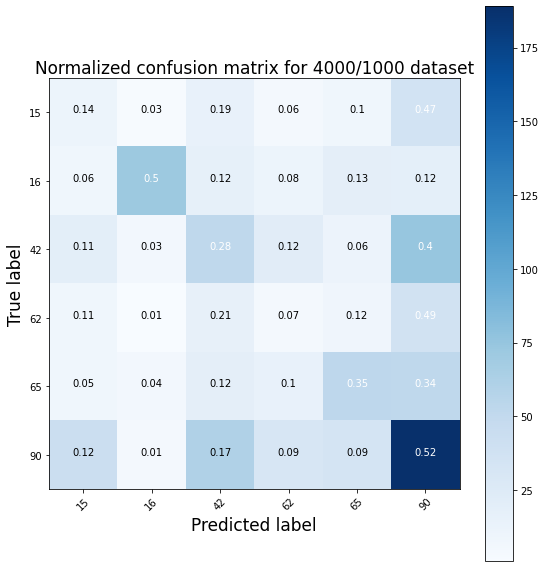

In [76]:
# Compute confusion matrix for last test
N = 4
y_test = test_labels_twed[N]
y_pred = pred_labels_twed[N]
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = [15, 16, 42, 62, 65, 90]
# plt.figure(figsize=(6, 6))
# plot_confusion_matrix(cnf_matrix, classes=class_names,
#                       title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for %d/%d dataset' % (n1_arr[N], n2_arr[N]))

print(classification_report(y_test, y_pred))

In [34]:
# checking mAP@k
mapk_twed = []
k = 10
for n1, n2 in zip(n1_arr, n2_arr):
    mapk, vec = m_av_p_k(path1, path2, n1, n2, c, k, dist_type="dtw")
    print("mAP@k for dataset [%d, %d, %d], and k=%d:" % (n1, n2, c, k), mapk)
    mapk_twed.append(mapk)

mAP@k for dataset [100, 25, 6], and k=10: 0.28263756613756613
mAP@k for dataset [500, 125, 6], and k=10: 0.29329639455782314
mAP@k for dataset [1000, 250, 6], and k=10: 0.320765141723356
mAP@k for dataset [2000, 500, 6], and k=10: 0.2567565863567649
mAP@k for dataset [4000, 1000, 6], and k=10: 0.2558541260393046


## Plots

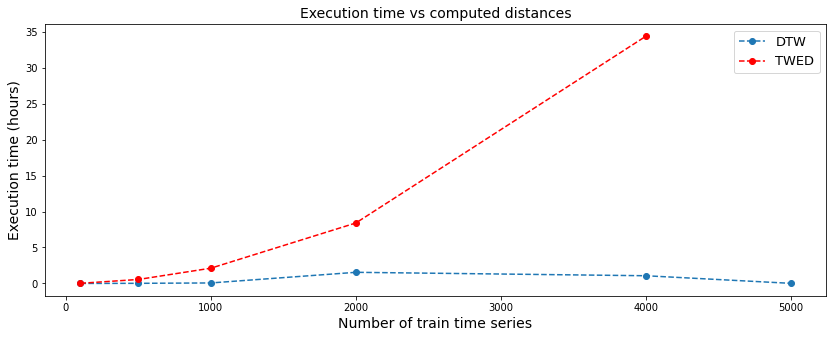

In [39]:
# execution time dtw distances
dtw_dist_time = [1.75, 63.82, 250.05, 5574.6, 3857.38, 60.73]
dtw_train_len = [100, 500, 1000, 2000, 4000, 5000]
twed_dist_time = [79.43, 1994.7, 7645.19, 30256.8, 123674.35]
twed_train_len = [100, 500, 1000, 2000, 4000]

fig = plt.figure(figsize=(14, 5))
plt.plot(dtw_train_len, np.array(dtw_dist_time) / 60 / 60, 'o--', label="DTW")
plt.plot(twed_train_len, np.array(twed_dist_time) / 60 / 60, 'ro--', label="TWED")
plt.xlabel("Number of train time series", fontsize=14)
plt.ylabel("Execution time (hours)", fontsize=14)
plt.title("Execution time vs computed distances", fontsize=14)
plt.legend(fontsize=13)

| Train set | Test set | classes | accuracy 1-NN classify DTW | accuracy 1-NN classify TWED |
| :-: | :-: | :-: | :-: | :-: |
| 10 | 10 | 2 | 0.8 | 0.4 | 
| 100 | 100 | 4 | 0.31 | 0.17 |
| 200 | 100 | 4 | 0.35 | 0.51 |
| 500 | 500 | 4 | 0.32 | 0.43 |
| 1000 | 500 | 4 | 0.35 | -- |
| 1000 | 1000 | 4 | 0.35 | -- |
| 1000 | 1000 | 10 | 0.25 | 0.32 |
| 2000 | 1000 | 14 | 0.18 | -- |
| 2000 | 2000 | 14 | 0.18 | -- |
| 5000 | 2847 | 14 | 0.18 | -- |
| 6278 | 1570 | 14 | 0.23 | -- |

| Train set | Test set | classes | mAP@k(k=10) DTW | mAP@k(k=10) TWED |
| :-: | :-: | :-: | :-: | :-: |
| 10 | 10 | 2 | 0.63 | 0.74 | 
| 100 | 100 | 4 | 0.33 | 0.27 |
| 200 | 100 | 4 | 0.33 | 0.17 |
| 500 | 500 | 4 | 0.29 | 0.30 |
| 1000 | 500 | 4 | 0.26 | -- |
| 1000 | 1000 | 4 | 0.25 | -- |
| 1000 | 1000 | 10 | 0.13 | 0.03 |
| 2000 | 1000 | 14 | 0.17 | -- |
| 2000 | 2000 | 14 | 0.16 | -- |
| 5000 | 2847 | 14 | 0.16 | -- |
| 6278 | 1570 | 14 | 0.18 | -- |

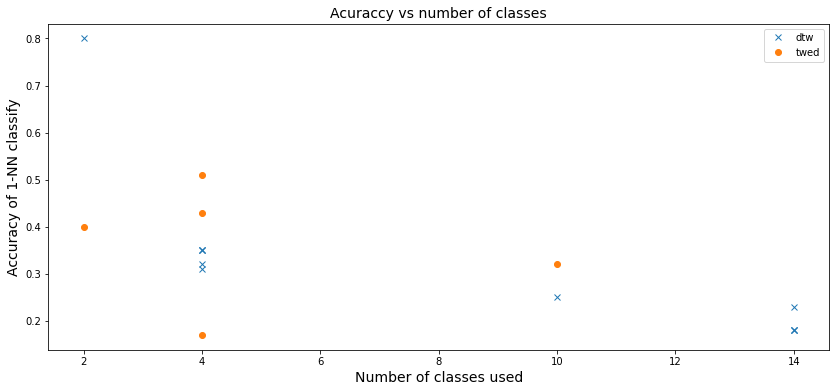

In [185]:
dtw_acc = [0.8, 0.31, 0.35, 0.32, 0.35, 0.35, 0.25, 0.18, 0.18, 0.18, 0.23]
fig = plt.figure(figsize=(14, 6))
plt.plot([2, 4, 4, 4, 4, 4, 10, 14, 14, 14, 14], dtw_acc, 'x', label="dtw")
twed_acc = [0.4, 0.17, 0.51, 0.43, 0.32]
plt.plot([2, 4, 4, 4, 10], twed_acc, 'o', label="twed")
plt.xlabel("Number of classes used", fontsize=14)
plt.ylabel("Accuracy of 1-NN classify", fontsize=14)
plt.title("Acuraccy vs number of classes", fontsize=14)
plt.legend()